In [1]:
#*Uncomment if running on colab*
#Set Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab
#"""
!git clone https://github.com/Fatmals/MS-DIP_Denoising.git
!mv MS-DIP_Denoising/* ./

Cloning into 'MS-DIP_Denoising'...
remote: Enumerating objects: 772, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 772 (delta 25), reused 11 (delta 11), pack-reused 742 (from 2)
Receiving objects: 100% (772/772), 10.00 MiB | 13.86 MiB/s, done.
Resolving deltas: 100% (436/436), done.


In [2]:
# -------------------------------
#  Import Libraries and Setup
# -------------------------------

from __future__ import print_function
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.optim

from skimage.metrics import peak_signal_noise_ratio as compare_psnr

#  DIP model imports (custom)
from models import *
from utils.denoising_utils import *

#  Torch backend settings
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
dtype = torch.cuda.FloatTensor  # Use GPU if available

# -------------------------------
#  Denoising Configuration
# -------------------------------

imsize = -1         # Use original image size
PLOT = True         # Enable plotting
sigma = 25          # Noise level (in range 0–255)
sigma_ = sigma / 255.0  # Normalized noise level


In [3]:
# Select Image to Denoise

# You can replace this path with any image of your choice.
# Examples:
# - 'data/denoising/Set5/butterfly.png'
# - 'data/denoising/Set14/pepper.png'


fname = 'data/denoising/Set5/woman.png'

Scale: 1.5


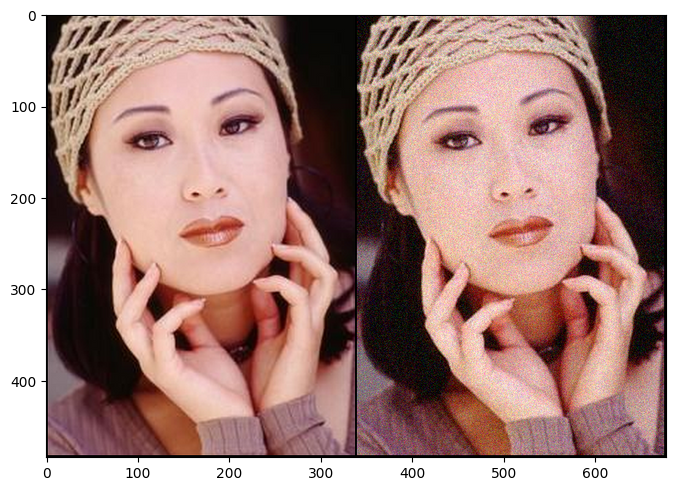

Scale: 1.0


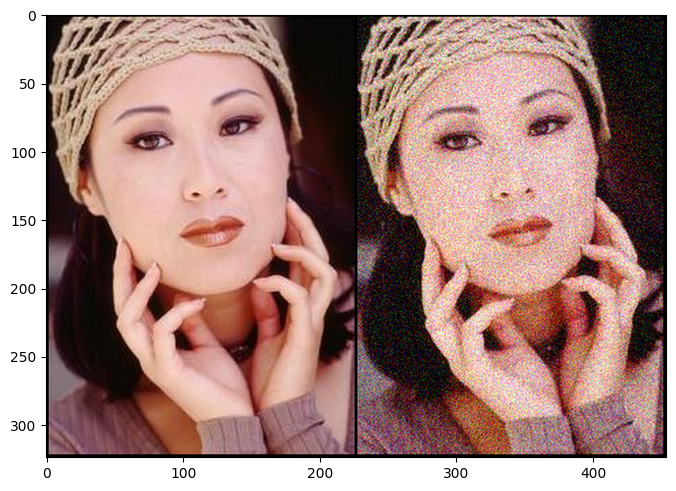

Scale: 0.8


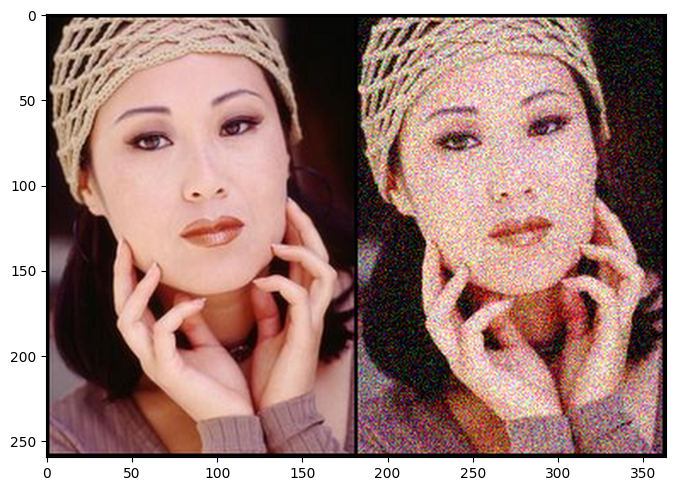

In [4]:
# -------------------------------------
#  Define Scales for Multi-Scale DIP
# -------------------------------------

scales = [1.5, 1.0, 0.8]  # High, original, and low resolutions

images = []        # List to store clean images at each scale
noisy_images = []  # List to store noisy versions

# -------------------------------------
# Load and Prepare Image at Each Scale
# -------------------------------------

if fname == 'data/denoising/Set5/woman.png':
    for scale in scales:
        # Load and crop image
        img_pil = crop_image(get_image(fname, imsize)[0], d=32)

        # Resize image based on scale
        img_pil = img_pil.resize(
            (int(img_pil.width * scale), int(img_pil.height * scale)),
            Image.LANCZOS
        )

        img_np = pil_to_np(img_pil)

        # Add synthetic Gaussian noise (scale-adaptive)
        scaled_sigma = sigma_ * (1 / scale)

        # Optional: Uncomment below for noise testing (e.g. disable noise at a specific scale)
        # specific_scale_to_disable = 0.8
        # if scale == specific_scale_to_disable:
        #     scaled_sigma = 0
        # else:
        #     scaled_sigma = sigma_ * (1 / scale)

        # Generate noisy image
        img_noisy_np = get_noisy_image(img_np, [scaled_sigma])[0]
        img_noisy_pil = np_to_pil(img_noisy_np)

        # Store results
        images.append(img_np)
        noisy_images.append(img_noisy_np)

    # -------------------------------------
    #  Visualize Clean vs Noisy Images
    # -------------------------------------
    if PLOT:
        for i, scale in enumerate(scales):
            print(f"Scale: {scale}")
            plot_image_grid([images[i], noisy_images[i]], 4, 6)

else:
    raise ValueError("Only Set5 'woman.png' is currently supported. Update logic to support other images.")


In [5]:
# --------------------------------------------
# MS-DIP Configuration and Network Setup
# --------------------------------------------

INPUT = 'noise'        # Type of input: 'noise' or 'meshgrid'
pad = 'reflection'     # Padding type
OPT_OVER = 'net'       # What to optimize: 'net', 'input', or both

reg_noise_std = 1./50.  # Std dev of noise input (regularization)
LR = 0.01               # Learning rate
OPTIMIZER = 'Adamax'    # Choose from: 'Adam', 'SGD', 'Adamax', 'RMSprop'

show_every = 100        # Print/save every N iterations
exp_weight = 0.5        # Exponential averaging weight (used to be 0.99)

# --------------------------------------------
#  Network Parameters and Initialization
# --------------------------------------------

if fname == 'data/denoising/Set5/woman.png':
    num_iter = 6000          # Training iterations
    input_depth = 32         # Input depth of noise tensor
    figsize = 4              # Plotting scale (not critical)

    # Initialize multi-scale skip network
    net = get_net(input_depth, 'skip', pad,
                  skip_n33d=64,       # Downsampling conv filters
                  skip_n33u=64,       # Upsampling conv filters
                  skip_n11=4,         # 1x1 conv filters
                  scales=scales,      # List of scales
                  num_scales=len(scales),
                  upsample_mode='bilinear').type(dtype)
else:
    raise ValueError("Only Set5 'woman.png' is currently supported.")

# --------------------------------------------
# Generate Multi-Scale Noise Inputs
# --------------------------------------------

net_inputs = [
    get_noise(input_depth, INPUT, (int(img_pil.size[1] * scale), int(img_pil.size[0] * scale)))
    .type(dtype).detach()
    for scale in scales
]

# --------------------------------------------
#  Parameter Count & Loss Function
# --------------------------------------------

# Count total trainable parameters
total_params = sum([np.prod(p.size()) for p in net.parameters()])
print(f'Total number of params: {total_params:,}')

# Define MSE Loss
mse = torch.nn.MSELoss().type(dtype)

# Convert noisy images to PyTorch tensors
img_noisy_torch = [np_to_torch(img).type(dtype) for img in noisy_images]


Total number of params: 796,869


Starting optimization with Adamax
Iteration 00000    Loss: 0.089610   PSNR_noisy: 10.393609   PSNR_gt: 10.298110   PSNR_gt_sm: 10.298110   SSIM: 0.111447


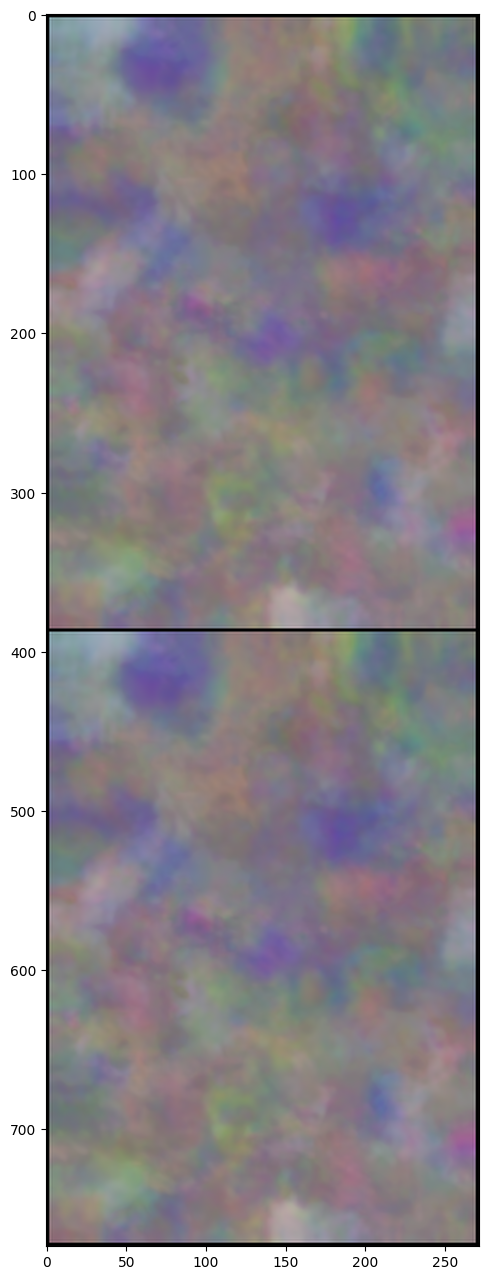

Iteration 00500    Loss: 0.002966   PSNR_noisy: 21.406506   PSNR_gt: 26.726304   PSNR_gt_sm: 27.723713   SSIM: 0.937229


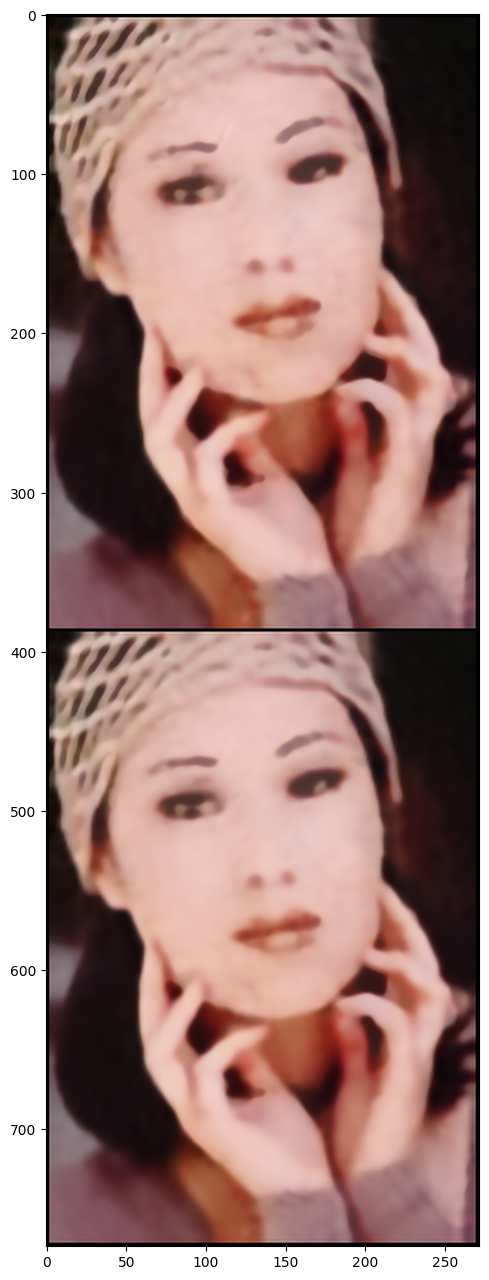

Iteration 01000    Loss: 0.002057   PSNR_noisy: 21.969081   PSNR_gt: 28.999196   PSNR_gt_sm: 30.262061   SSIM: 0.951983


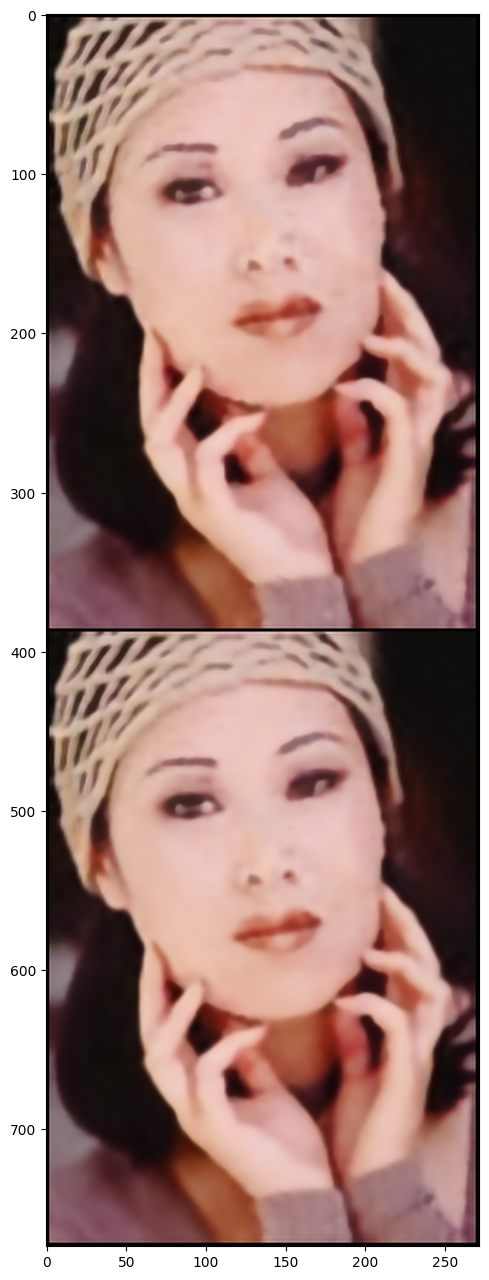

Iteration 01500    Loss: 0.001721   PSNR_noisy: 22.222718   PSNR_gt: 30.130583   PSNR_gt_sm: 31.429160   SSIM: 0.957697


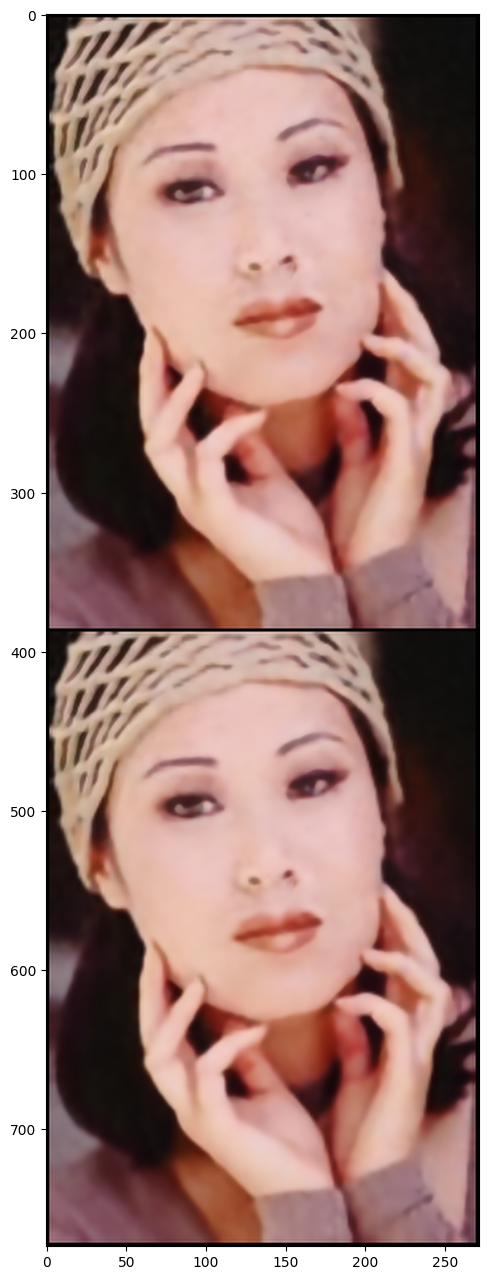

Iteration 02000    Loss: 0.001445   PSNR_noisy: 22.415934   PSNR_gt: 31.587390   PSNR_gt_sm: 32.511915   SSIM: 0.964194


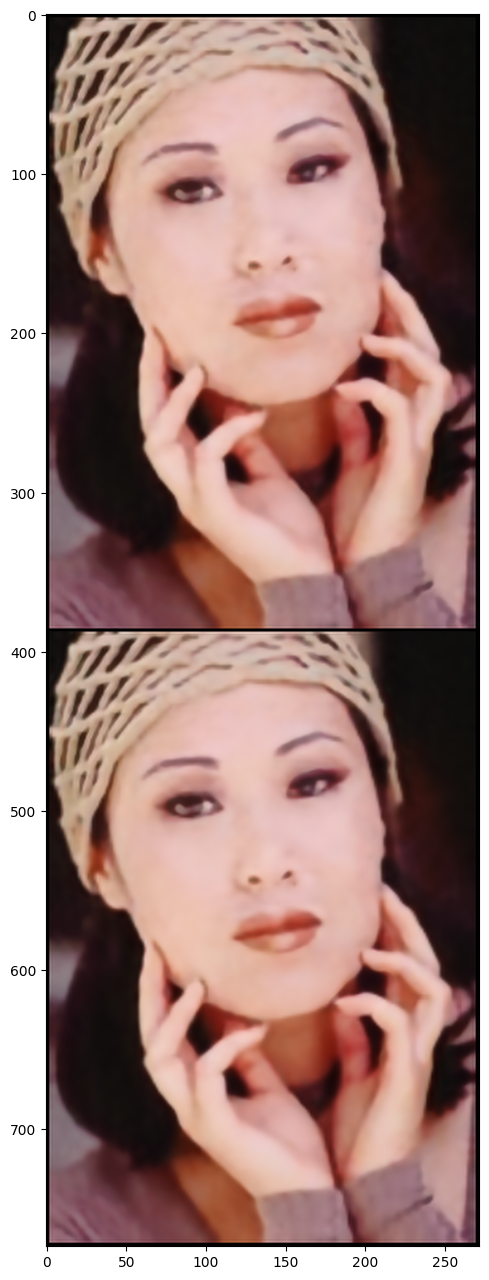

In [ ]:
# -------------------------------------------------------
# MS-DIP Training Loop: Multi-Scale Closure + Optimiser
# -------------------------------------------------------

import torch.nn.functional as F
from skimage.transform import resize
from skimage.metrics import structural_similarity as ssim
from utils.denoising_utils import plot_image_grid

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = net.to(device)

#  Backup inputs and noise for multi-scale optimization
net_inputs_saved = [ni.detach().clone() for ni in net_inputs]
noise = [ni.detach().clone() for ni in net_inputs]

out_avg = None
last_net = None
psrn_noisy_last = 0
i = 0  # Iteration counter

def closure():
    global i, out_avg, psrn_noisy_last, last_net, net_inputs, img_noisy_torch

    #  Add noise regularisation (per scale)
    if reg_noise_std > 0:
        net_inputs = [
            saved + (n.normal_() * reg_noise_std)
            for saved, n in zip(net_inputs_saved, noise)
        ]

    # Ensure 4D input shape
    net_inputs = [ni.unsqueeze(0) if ni.dim() == 3 else ni for ni in net_inputs]

    # Forward pass
    out = net(net_inputs)

    # Exponential moving average of output
    out_avg = out.detach() if out_avg is None else (out_avg * exp_weight + out.detach() * (1 - exp_weight))

    #  Resize and average noisy inputs if needed
    if isinstance(img_noisy_torch, list):
        max_size = max([img.shape[-2:] for img in img_noisy_torch])
        img_noisy_torch = torch.stack([
            F.interpolate(img.unsqueeze(0) if img.dim() == 3 else img,
                          size=max_size, mode="bilinear", align_corners=False).squeeze(0)
            for img in img_noisy_torch
        ], dim=0).mean(dim=0)

    if img_noisy_torch.dim() == 3:
        img_noisy_torch = img_noisy_torch.unsqueeze(0)

    # Resize target to match output
    img_noisy_torch_resized = F.interpolate(img_noisy_torch, size=out.shape[-2:], mode="bilinear", align_corners=False)

    # Loss & backward
    total_loss = mse(out, img_noisy_torch_resized)
    total_loss.backward()

    # Convert to NumPy for metric evaluation
    out_np = torch_to_np(out).astype(np.float32)
    out_avg_np = torch_to_np(out_avg).astype(np.float32)

    img_noisy_np_resized = resize(img_noisy_np, out_np.shape, anti_aliasing=True).astype(np.float32)
    img_np_resized = resize(img_np, out_np.shape, anti_aliasing=True).astype(np.float32)

    # Normalize if needed
    for arr in [img_noisy_np_resized, img_np_resized, out_np, out_avg_np]:
        if arr.max() > 1:
            arr /= 255.0

    # Metrics
    psnr_noisy = compare_psnr(img_noisy_np_resized, out_np, data_range=1.0)
    psnr_gt = compare_psnr(img_np_resized, out_np, data_range=1.0)
    psnr_gt_sm = compare_psnr(img_np_resized, out_avg_np, data_range=1.0)
    win_size = min(7, min(img_np_resized.shape[:2]))
    ssim_value = ssim(img_np_resized, out_np, data_range=1.0, win_size=win_size)

    # Log + plot
    if i % 500 == 0 or i == num_iter - 1:
        print(
            "Iteration %05d    Loss: %f   PSNR_noisy: %f   PSNR_gt: %f   PSNR_gt_sm: %f   SSIM: %f"
            % (i, total_loss.item(), psnr_noisy, psnr_gt, psnr_gt_sm, ssim_value),
            flush=True
        )

        if PLOT and i % show_every == 0:
            plot_image_grid([
                np.clip(torch_to_np(out), 0, 1),
                np.clip(torch_to_np(out_avg), 0, 1)
            ], factor=figsize, nrow=1)

    i += 1
    return total_loss

# Run optimisation
p = get_params(OPT_OVER, net, net_inputs)
optimize(OPTIMIZER, p, closure, LR, num_iter)
